In [20]:
## Change to the path where you want to save the model, or where you want to load the model from:
ROOT_PATH = '/content/drive/MyDrive/2022 files/CS 577/Assignments/hw1'

# Programming Questions: Q4

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!wget http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data -P /content/drive/MyDrive/2022\ files/CS\ 577/Assignments/hw1

--2022-09-14 17:51:30--  http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1102815 (1.1M) [application/x-httpd-php]
Saving to: ‘/content/drive/MyDrive/2022 files/CS 577/Assignments/hw1/communities.data’

communities.data    100%[===================>]   1.05M  2.62MB/s    in 0.4s    

2022-09-14 17:51:31 (2.62 MB/s) - ‘/content/drive/MyDrive/2022 files/CS 577/Assignments/hw1/communities.data’ saved [1102815/1102815]



In [17]:
import pandas as pd
import os
import numpy as np
import tensorflow
from tensorflow import convert_to_tensor as tensor
from tensorflow.keras import optimizers
import keras
from keras import models, layers
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score

In [4]:
URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data'

### Load the data

In [5]:
np.random.seed(42)
data = pd.read_csv(URL, delim_whitespace = False, header=None)
names = data.sample(frac=1).reset_index(drop=True).iloc[:,3]

def load_crime_data(data_url, split_ratio=0.8):
    data = pd.read_csv(data_url, delim_whitespace = False, header=None)
    np.random.seed(42)
    data = data.sample(frac=1).reset_index(drop=True)
    np.random.shuffle(data.values)
    data.reset_index(drop=True)
    names = data.iloc[:,3]
    for i in range(5):
        data.pop(data.columns[0])
    labels = data.pop(data.columns[-1])

    data = data.replace("?",0) ## lots of '?' in matrix. Make 0 so we can still normalize.
    data = data.astype(float)  ## some numbers entered as strings rather than numeric values.
    
    n_train = int(split_ratio*len(data))
    X_trn, X_tst = np.array(data[:n_train]), np.array(data[n_train:])
    y_trn, y_tst = np.array(labels[:n_train]), np.array(labels[n_train:])
    return (X_trn, y_trn), (X_tst, y_tst)

In [6]:
(X_trn_no_norm, y_trn), (X_tst_no_norm, y_tst) = load_crime_data(URL)

print(f'N = {X_trn_no_norm.shape[0] + X_tst_no_norm.shape[0]}')
print(f'Train values shape: {X_trn_no_norm.shape}')
print(f'Test values shape:  {X_tst_no_norm.shape}')
print(f'Train labels shape: {y_trn.shape}')
print(f'Test labels shape: {y_tst.shape}')
print(f'Rates: {list(set(y_trn))}')
print(f'Community names: {[n for n in names]}')

N = 1994
Train values shape: (1595, 122)
Test values shape:  (399, 122)
Train labels shape: (1595,)
Test labels shape: (399,)
Rates: [0.48, 0.52, 0.51, 0.47, 0.27, 0.25, 0.0, 1.0, 0.76, 0.26, 0.5, 0.75, 0.84, 0.22, 0.79, 0.23, 0.21, 0.54, 0.13, 0.88, 0.38, 0.97, 0.72, 0.2, 0.45, 0.42, 0.18, 0.43, 0.19, 0.44, 0.46, 0.41, 0.85, 0.69, 0.15, 0.17, 0.16, 0.55, 0.8, 0.14, 0.89, 0.39, 0.64, 0.73, 0.57, 0.82, 0.63, 0.59, 0.58, 0.67, 0.35, 0.6, 0.68, 0.36, 0.12, 0.62, 0.93, 0.11, 0.77, 0.91, 0.86, 0.61, 0.7, 0.95, 0.1, 0.09, 0.08, 0.56, 0.81, 0.4, 0.65, 0.9, 0.49, 0.24, 0.74, 0.83, 0.07, 0.06, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.05, 0.04, 0.53, 0.28, 0.78, 0.37, 0.87, 0.03, 0.71, 0.96, 0.02, 0.01, 0.66]
Community names: ['Rosevillecity', 'NorthHuntingdontownship', 'Gallowaytownship', 'Nortontown', 'LosAltoscity', 'SouthMilwaukeecity', 'SanRafaelcity', 'Lauderhillcity', 'MenomoneeFallsvillage', 'PortHuenemecity', 'Brownsvillecity', 'Richlandcity', 'Hamdentown', 'LosGatostown', 'Readingcity', 'W

### Normalize

In [7]:
mean_data = np.concatenate([X_trn_no_norm,X_tst_no_norm]).mean(axis=0)
std_data  = np.concatenate([X_trn_no_norm,X_tst_no_norm]).std(axis=0)

X_trn = (X_trn_no_norm - mean_data)/std_data
X_tst = (X_tst_no_norm - mean_data)/std_data

### Create, compile, and fit model, using k-fold method

In [8]:
k = 5
k_fold = KFold(n_splits=k)


opt     = optimizers.Adam(learning_rate=0.01)
loss_f  = keras.losses.mean_squared_error
metrics = ['mae']
epochs = 150
batch_size = 256

draft_trn_k_MAEs = []
draft_val_k_MAEs = []

count = 0
for train_indices, val_indices in k_fold.split(X_trn):
    print(f'k = {count}\n')
    X_trn_, X_val_ = X_trn[train_indices], X_trn[val_indices]
    y_trn_, y_val_ = y_trn[train_indices], y_trn[val_indices]

    draft_model = models.Sequential()
    draft_model.add(layers.Dense(16, activation='relu', input_shape=(X_trn_.shape[1],)))
    draft_model.add(layers.Dense(16))
    draft_model.add(layers.Dense(1))

    draft_model.compile(optimizer = opt, loss = loss_f, metrics = metrics)

    draft_history = draft_model.fit(X_trn_, 
                                    y_trn_, 
                                    epochs=epochs,  
                                    batch_size=batch_size,
                                    validation_data = (X_val_,y_val_),
                                    verbose=True)
    
    draft_trn_k_MAEs.append(draft_history.history['mae'])
    draft_val_k_MAEs.append(draft_history.history['val_mae'])
    test_results = draft_model.evaluate(X_trn_,y_trn_,return_dict=True)
    count += 1

k = 0

Epoch 1/150
5/5 [==============================] - 1s 50ms/step - loss: 0.4397 - mae: 0.4912 - val_loss: 0.1581 - val_mae: 0.2795
Epoch 2/150
5/5 [==============================] - 0s 11ms/step - loss: 0.1337 - mae: 0.2452 - val_loss: 0.0489 - val_mae: 0.1790
Epoch 3/150
5/5 [==============================] - 0s 11ms/step - loss: 0.0583 - mae: 0.1854 - val_loss: 0.0399 - val_mae: 0.1495
Epoch 4/150
5/5 [==============================] - 0s 8ms/step - loss: 0.0381 - mae: 0.1451 - val_loss: 0.0293 - val_mae: 0.1262
Epoch 5/150
5/5 [==============================] - 0s 9ms/step - loss: 0.0302 - mae: 0.1325 - val_loss: 0.0280 - val_mae: 0.1229
Epoch 6/150
5/5 [==============================] - 0s 12ms/step - loss: 0.0258 - mae: 0.1176 - val_loss: 0.0245 - val_mae: 0.1075
Epoch 7/150
5/5 [==============================] - 0s 8ms/step - loss: 0.0230 - mae: 0.1095 - val_loss: 0.0218 - val_mae: 0.1011
Epoch 8/150
5/5 [==============================] - 0s 9ms/step - loss: 0.0208 - mae: 0

### Plot results from draft model

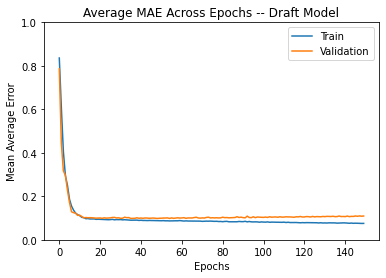

In [14]:
average_trn_MAEs = []
average_val_MAEs = []


for e in range(150):
    avg_trn = np.mean([trn[e] for trn in draft_trn_k_MAEs])
    avg_val = np.mean([val[e] for val in draft_val_k_MAEs])

    average_trn_MAEs.append(avg_trn)
    average_val_MAEs.append(avg_val)

plt.plot(range(150),average_trn_MAEs,label='Train')
plt.plot(range(150),average_val_MAEs,label='Validation')
plt.ylabel('Mean Average Error')
plt.xlabel('Epochs')
plt.ylim(0,1)
plt.legend()
plt.title('Average MAE Across Epochs -- Draft Model')
plt.show()

#### It's a close call, but it seems reasonable to say the validation MAE stops decreasing around 100 epochs.

## Final model

### Tune hyperparameters and network architecture based on draft model performance

In [10]:
## The initial model seemed reasonable, except trained for more epochs than was necessary. Simply reduce numer of training epochs.

opt     = optimizers.Adam(learning_rate=0.01)
loss_f  = keras.losses.mean_squared_error
metrics = ['mae']

epochs = 100
batch_size = 256

final_model = models.Sequential()
final_model.add(layers.Dense(16, activation='relu', input_shape=(X_trn_.shape[1],)))
final_model.add(layers.Dense(16))
final_model.add(layers.Dense(1))

### Compile and fit model

In [11]:
final_model.compile(optimizer = opt, loss = loss_f, metrics = metrics)
final_history = final_model.fit(X_trn, 
                                y_trn, 
                                epochs=epochs,  
                                batch_size=batch_size)

test_results = draft_model.evaluate(X_tst, y_tst,return_dict=True)

Epoch 1/100
7/7 [==============================] - 0s 3ms/step - loss: 0.3309 - mae: 0.4164
Epoch 2/100
7/7 [==============================] - 0s 5ms/step - loss: 0.0745 - mae: 0.2009
Epoch 3/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0414 - mae: 0.1441
Epoch 4/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0261 - mae: 0.1124
Epoch 5/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0224 - mae: 0.1049
Epoch 6/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0204 - mae: 0.1001
Epoch 7/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0199 - mae: 0.0971
Epoch 8/100
7/7 [==============================] - 0s 5ms/step - loss: 0.0191 - mae: 0.0974
Epoch 9/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0188 - mae: 0.0928
Epoch 10/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0185 - mae: 0.0966
Epoch 11/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0184 

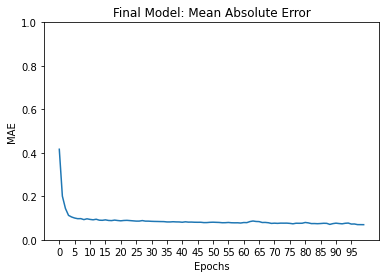

In [12]:
final_MAEs = final_history.history['mae']

plt.plot(range(epochs),final_MAEs)
plt.ylim(0,1)
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.xticks(range(epochs)[0::5])
plt.title('Final Model: Mean Absolute Error')
plt.show()

In [15]:
MAE_tst = test_results['mae']
print()
print(f'Draft model MAE, averaged across k training subsets, epoch=100:   {round(100*average_trn_MAEs[epochs-1],5)}%')
print(f'New model final MAE, training set, epoch=100:                     {round(100*final_MAEs[-1],5)}%')
print()
print(f'Draft model MAE, averaged across k validation subsets, epoch=100: {round(100*average_val_MAEs[epochs-1],5)}%')
print(f'New model final MAE, test set, epoch=100:                         {round(100*MAE_tst,5)}%')
print()
predictions = final_model.predict(X_tst)
predictions = np.asarray([round(p[0],3) for p in predictions])
prediction_results = pd.DataFrame({'Predicted':list(predictions),'Actual':[v for v in list(y_tst)]})
print('Sample predictions compared to ground truth:')
display(prediction_results[:10])


Draft model MAE, averaged across k training subsets, epoch=100:   8.22615%
New model final MAE, training set, epoch=100:                     6.95336%

Draft model MAE, averaged across k validation subsets, epoch=100: 10.38639%
New model final MAE, test set, epoch=100:                         10.43174%

Sample predictions compared to ground truth:


,Predicted,Actual
0,0.201,0.08
1,0.404,0.11
2,0.395,0.10
3,0.510,0.84
4,0.219,0.22
5,-0.028,0.04
6,0.219,0.12
7,0.224,0.12
8,1.021,0.42
9,0.271,0.22


In [22]:
final_model.save(os.path.join(ROOT_PATH, 'Q4_model.h5'))
model = tensorflow.keras.models.load_model(os.path.join(ROOT_PATH, 'Q4_model.h5'))